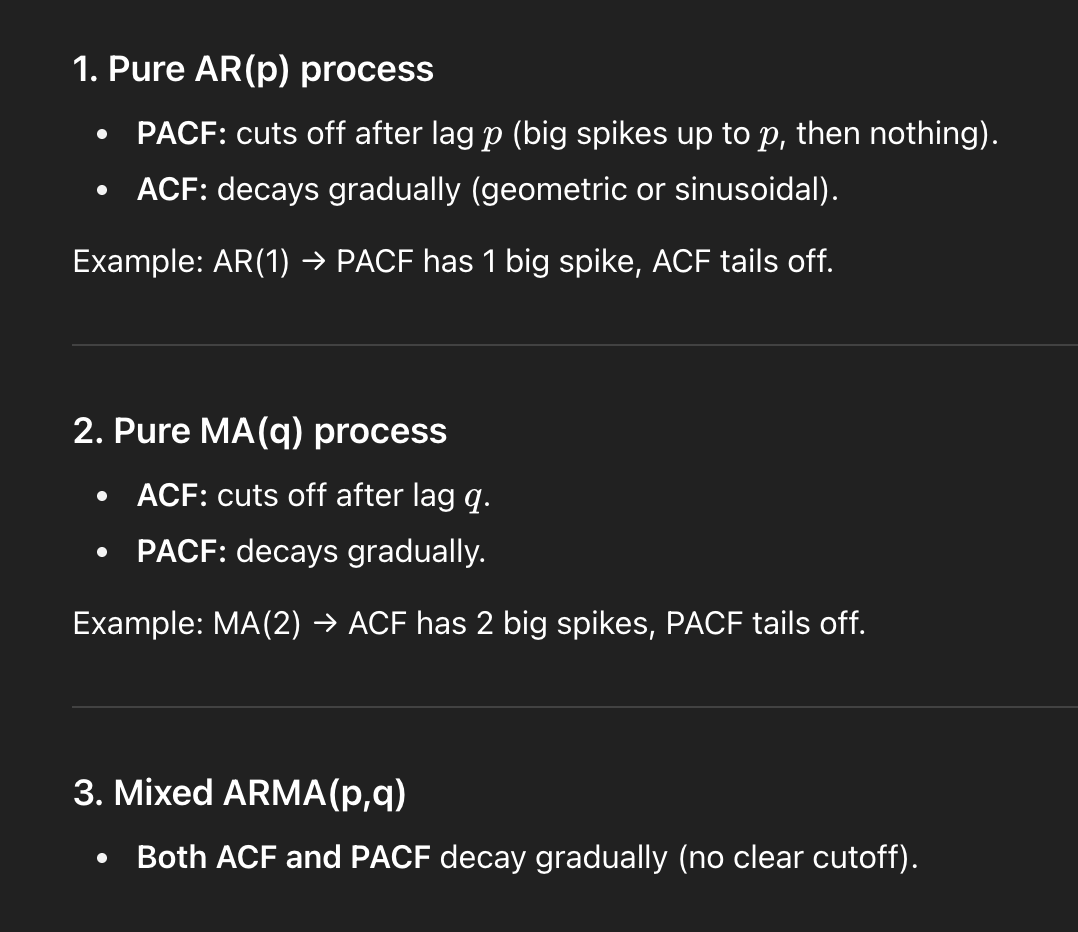
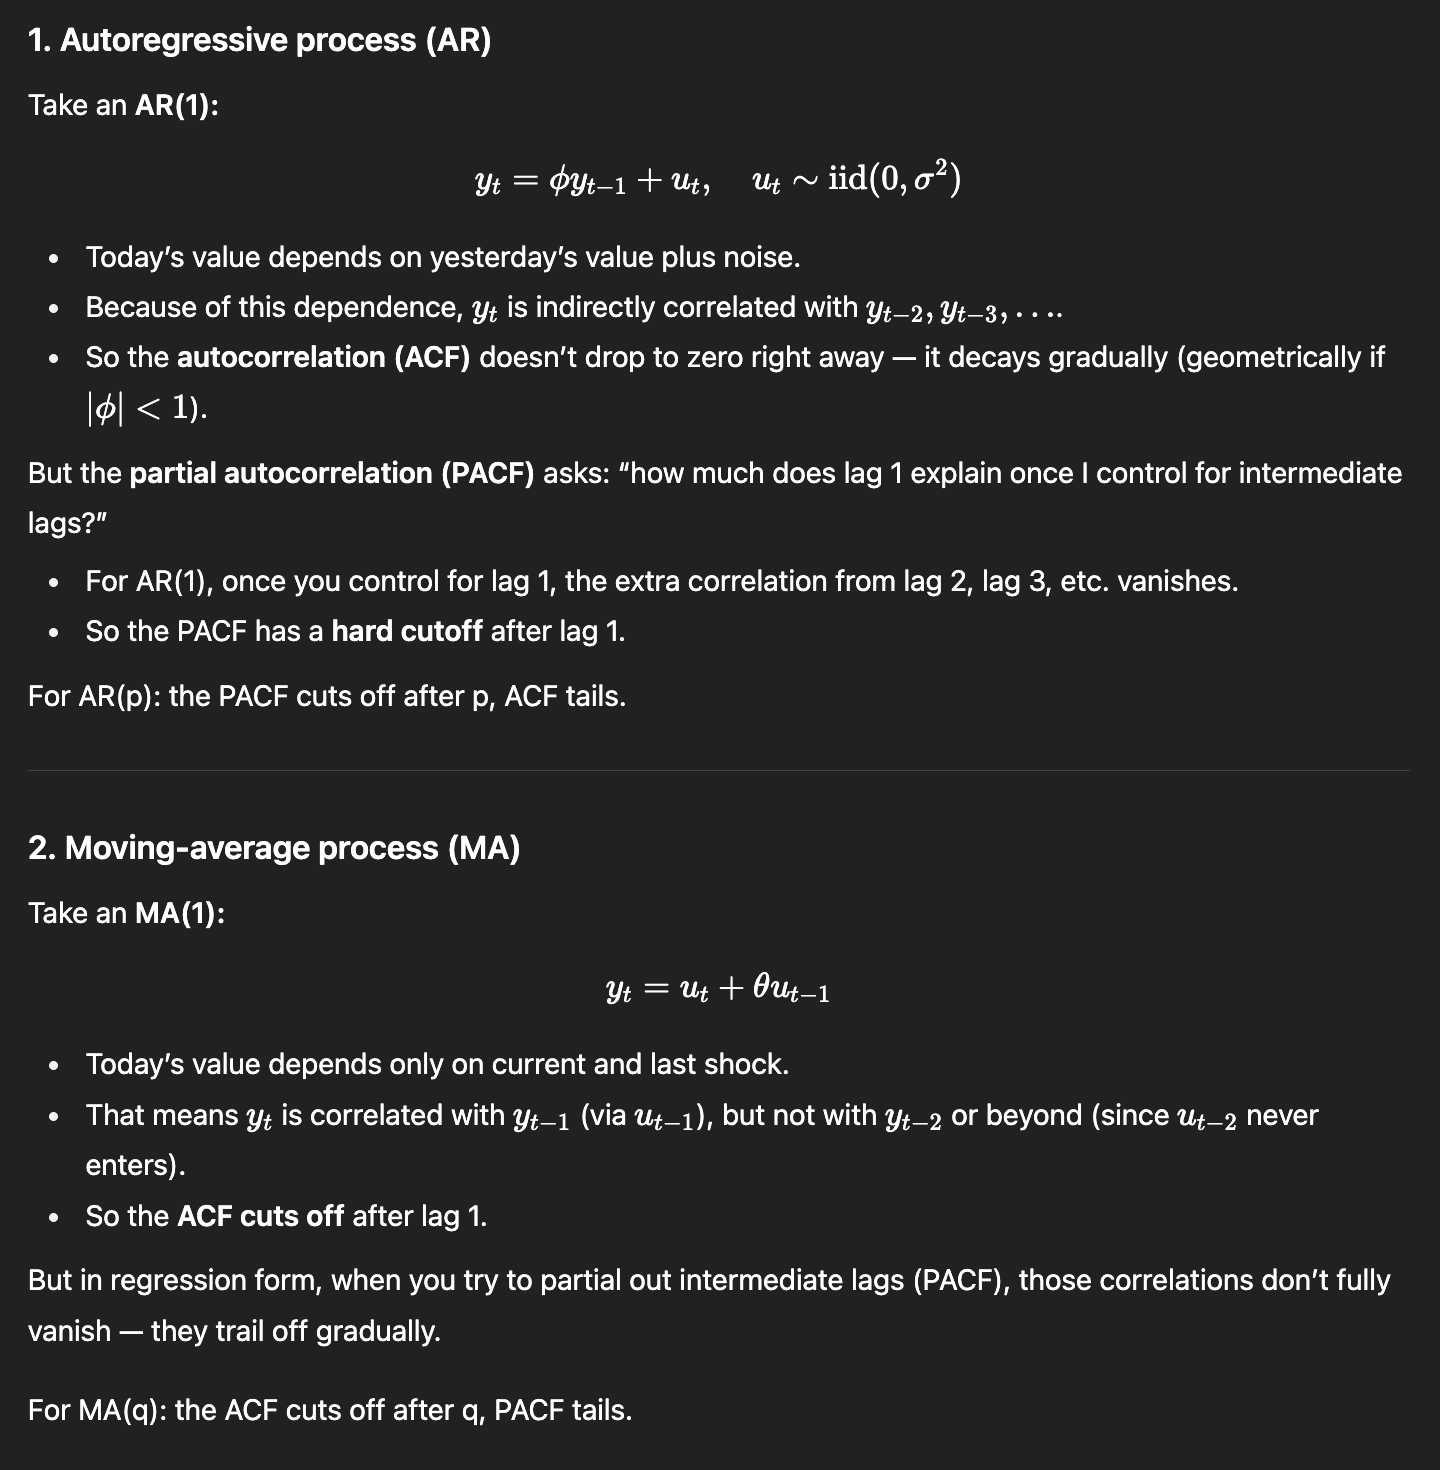

In [4]:
import numpy as np
import matplotlib.pyplot as plt


normal = np.random.normal

RMSE (observations vs. true state): 1.0174
RMSE (Kalman filtered mean vs. true state): 0.7374


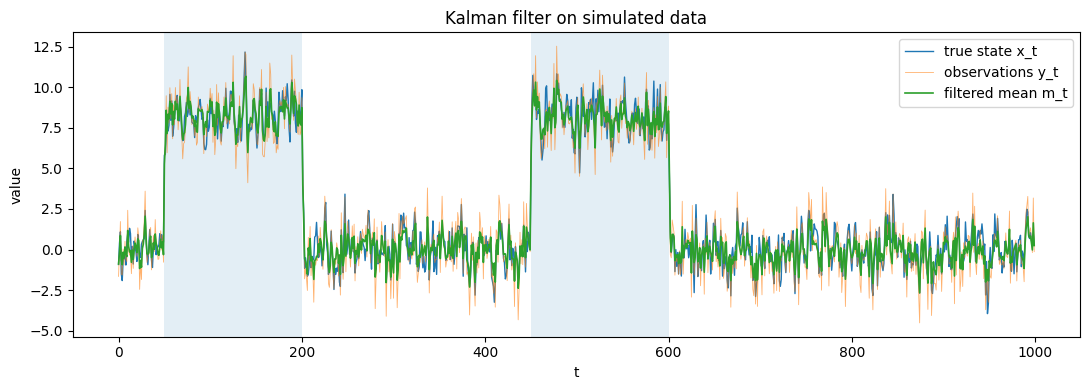

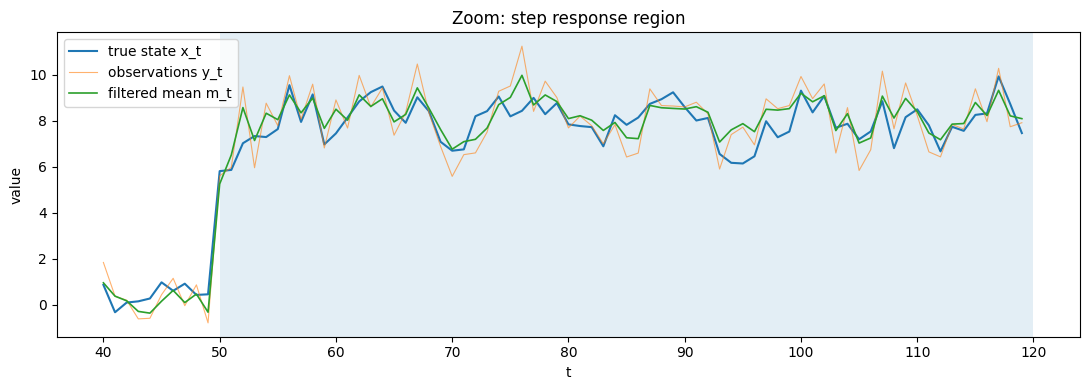

In [ ]:
# Simulate and solve the Kalman filter in Python for the model shown in the slide.
# Model:
#   x_{t+1} = a x_t + u_t + v_t,  v_t ~ N(0, Q)
#   y_t     = x_t + e_t,          e_t ~ N(0, R)
# Parameters:
#   a = 0.4, Q = 1, R = 1, N = 1000
#   u_t = 5 for t in [50..200] U [450..600], else 0
#
# We: (1) simulate data, (2) run the standard Kalman filter with known params,
# (3) plot x_true, observations y, and filtered mean m_t, and (4) report RMSEs.

# ---- Parameters ----
N = 1000
a = 0.4
Q = 1.0  # process noise variance
R = 1.0  # observation noise variance

# Control input u_t
u = np.zeros(N)
u[50:201] = 5.0       # 50..200 inclusive (Python stop is exclusive)
u[450:601] = 5.0      # 450..600 inclusive

# ---- Simulate the state-space model ----
rng = np.random.default_rng(42)
x = np.zeros(N + 1)  # include x_0
x[0] = rng.normal(0.0, 1.0)  # x0 ~ N(0,1)
v = rng.normal(0.0, np.sqrt(Q), size=N)  # process noise
e = rng.normal(0.0, np.sqrt(R), size=N)  # measurement noise

for t in range(N): x[t+1] = a * x[t] + u[t] + v[t]

y = x[1:] + e  # observations y_1..y_N correspond to x_1..x_N

# ---- Kalman Filter ----
m = np.zeros(N + 1)  # filtered mean for x_t given y_1..y_t; start with prior for x0
P = np.zeros(N + 1)  # filtered variance
m[0] = 0.0           # prior mean for x0
P[0] = 1.0           # prior variance for x0

# Store predicted means for plotting if desired
m_pred = np.zeros(N)   # mean of x_t given y_1..y_{t-1}
P_pred = np.zeros(N)

for t in range(N):
    # Predict x_t from x_{t-1}
    m_pred[t] = a * m[t] + u[t]
    P_pred[t] = a * P[t] * a + Q

    # Innovation
    S = P_pred[t] + R
    K = P_pred[t] / S  # Kalman gain (scalar case)

    # Update with y_t
    m[t+1] = m_pred[t] + K * (y[t] - m_pred[t])
    P[t+1] = (1 - K) * P_pred[t]

# Remove t=0 prior for alignment with x[1:], y
m_filt = m[1:]
P_filt = P[1:]

# ---- Error metrics ----
rmse_obs = np.sqrt(np.mean((y - x[1:])**2))          # between observation and true state
rmse_filt = np.sqrt(np.mean((m_filt - x[1:])**2))    # between filtered estimate and true state

print(f"RMSE (observations vs. true state): {rmse_obs:.4f}")
print(f"RMSE (Kalman filtered mean vs. true state): {rmse_filt:.4f}")

# ---- Plots ----
# Plot 1: full series
plt.figure(figsize=(11, 4))
plt.plot(x[1:], label="true state x_t", linewidth=1.0)
plt.plot(y, label="observations y_t", linewidth=0.6, alpha=0.6)
plt.plot(m_filt, label="filtered mean m_t", linewidth=1.2)
# Shade control-on intervals
for s, eidx in [(50, 200), (450, 600)]:
    plt.axvspan(s, eidx, alpha=0.12)
plt.title("Kalman filter on simulated data")
plt.xlabel("t")
plt.ylabel("value")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: zoom window to see tracking (e.g., t=40..120)
plt.figure(figsize=(11, 4))
t0, t1 = 40, 120
plt.plot(range(t0, t1), x[1:][t0:t1], label="true state x_t")
plt.plot(range(t0, t1), y[t0:t1], label="observations y_t", linewidth=0.8, alpha=0.6)
plt.plot(range(t0, t1), m_filt[t0:t1], label="filtered mean m_t", linewidth=1.2)
plt.axvspan(50, 120, alpha=0.12)
plt.title("Zoom: step response region")
plt.xlabel("t")
plt.ylabel("value")
plt.legend()
plt.tight_layout()
plt.show()



/var/folders/nb/bcl7qtp16rv9lpgrryc9q4c00000gn/T/ipykernel_7457/607316391.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loglik_coarse[i] += -0.5 * ( np.log( np.linalg.det(Ri) ) + (tildeY.T @ np.linalg.inv(Ri) @ tildeY) )


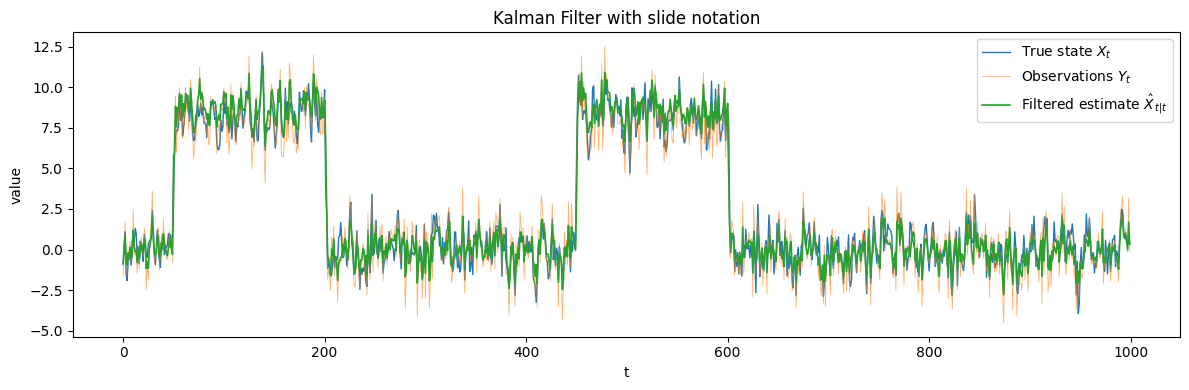

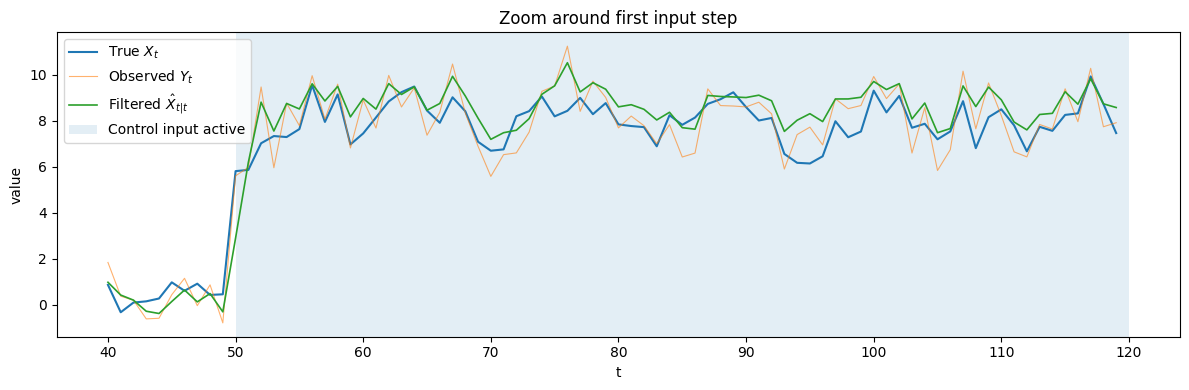

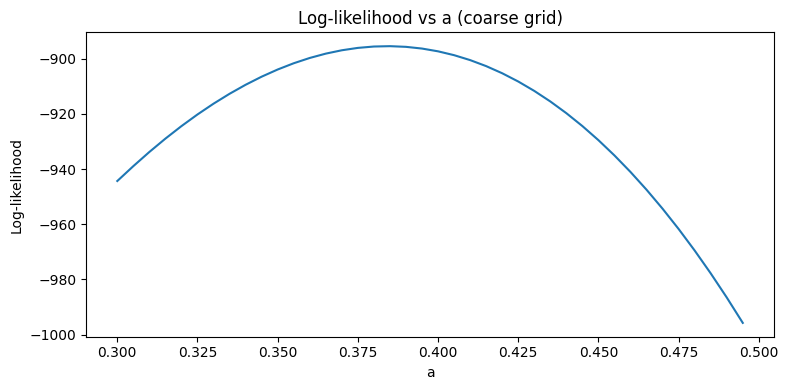

In [28]:
# Let's reproduce the user's simulation and Kalman filter, then add
# the log-likelihood sweep over a ∈ {0.1, 0.2, ..., 0.5} and plot it.

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Parameters
# ----------------------------
N = 1000
a_true = 0.4  # true value used to simulate
A_true = np.array([[a_true]])
B = np.array([[1.0]])
C = np.array([[1.0]])
Sigma1 = np.array([[1.0]]) # process noise covariance
Sigma2 = np.array([[1.0]]) # measurement noise covariance

# Control sequence u_t
u = np.zeros(N)
u[50:201] = 5.0
u[450:601] = 5.0

# ----------------------------
# Simulate X_t, Y_t
# ----------------------------
rng = np.random.default_rng(42)
X = np.zeros((N+1,1))
X[0,0] = rng.normal(0.0, 1.0)

e1 = rng.normal(0.0, 1.0, size=N).reshape(-1,1)
e2 = rng.normal(0.0, 1.0, size=N).reshape(-1,1)

for t in range(1, N+1):
    X[t] = A_true @ X[t-1] + B * u[t-1] + e1[t-1]

Y = (C @ X[1:].T).T + e2

# ----------------------------
# Kalman Filter (with true A for demonstration)
# ----------------------------
mu0 = np.array([[0.0]])
V0 = np.array([[1.0]])

Xhat_t_t = np.zeros((N,1))
Xhat_t_tminus1 = np.zeros((N,1))

Xhat_prev_t_t = mu0.copy()
Sigma_prev_t_t = V0.copy()


a_grid_coarse = np.arange(0.3, 0.5, 0.005)
loglik_coarse = np.empty_like(a_grid_coarse)

for i, a in enumerate(a_grid_coarse):
    A_true = np.array([[a]])
    for t in range(N):
        # Predict
        Xhat_pred = A_true @ Xhat_prev_t_t + B * (u[t-1] if t > 0 else 0.0)
        Sigma_pred = A_true @ Sigma_prev_t_t @ A_true.T + Sigma1
        S = C @ Sigma_pred @ C.T + Sigma2
        
        # reconstruction
        K = Sigma_pred @ C.T @ np.linalg.inv(S)
        tildeY = Y[t] - (C @ Xhat_pred)
        Xhat_upd = Xhat_pred + K @ tildeY
        Sigma_upd = (np.eye(1) - K @ C) @ Sigma_pred
        
        Ri = S
        loglik_coarse[i] += -0.5 * ( np.log( np.linalg.det(Ri) ) + (tildeY.T @ np.linalg.inv(Ri) @ tildeY) ) 
            
        # Store for plotting
        Xhat_t_tminus1[t] = Xhat_pred
        Xhat_t_t[t] = Xhat_upd
        
        # Roll forward
        Xhat_prev_t_t = Xhat_upd
        Sigma_prev_t_t = Sigma_upd

# ----------------------------
# Plots of states/observations/filtered estimates
# ----------------------------
X_true = X[1:,0]
Y_obs = Y[:,0]
Xhat_filtered = Xhat_t_t[:,0]

# Plot full time series
plt.figure(figsize=(12,4))
plt.plot(X_true, label="True state $X_t$", linewidth=1.0)
plt.plot(Y_obs, label="Observations $Y_t$", linewidth=0.6, alpha=0.6)
plt.plot(Xhat_filtered, label="Filtered estimate $\\hat X_{t|t}$", linewidth=1.2)
plt.title("Kalman Filter with slide notation")
plt.xlabel("t")
plt.ylabel("value")
plt.legend()
plt.tight_layout()
plt.show()

# Zoom around first input step
plt.figure(figsize=(12,4))
t0, t1 = 40, 120
plt.plot(range(t0,t1), X_true[t0:t1], label="True $X_t$")
plt.plot(range(t0,t1), Y_obs[t0:t1], label="Observed $Y_t$", linewidth=0.8, alpha=0.6)
plt.plot(range(t0,t1), Xhat_filtered[t0:t1], label="Filtered $\\hat X_{t|t}$", linewidth=1.2)
plt.axvspan(50, 120, alpha=0.12, label="Control input active")
plt.title("Zoom around first input step")
plt.xlabel("t")
plt.ylabel("value")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
# plt.plot(a_grid_coarse, loglik_coarse, marker='o') 
# plot without dots
plt.plot(a_grid_coarse, loglik_coarse)
plt.xlabel("a")
plt.ylabel("Log-likelihood")
plt.title("Log-likelihood vs a (coarse grid)")
plt.tight_layout()
plt.show()

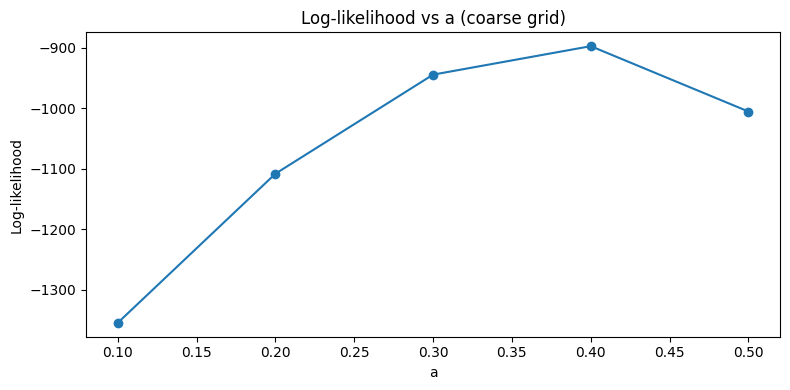

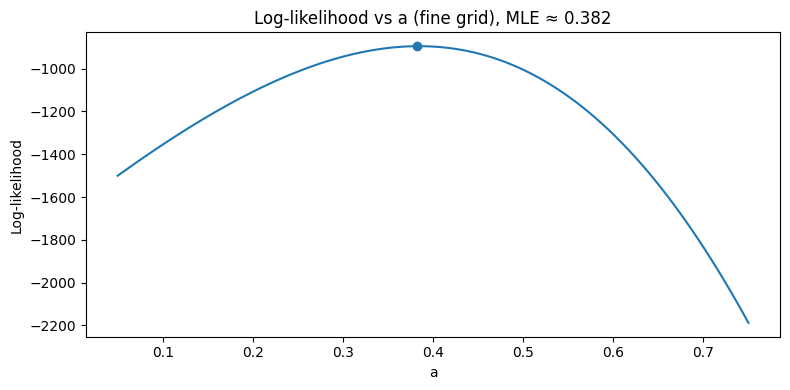

(0.4, 0.3823232323232323)

In [ ]:
# ----------------------------
# Log-likelihood sweep over a ∈ {0.1, 0.2, ..., 0.5}
# ----------------------------

def kalman_loglik_for_a(a, Y, u, mu0, V0, Sigma1, Sigma2, B, C):
    """
    Run a 1D Kalman filter for given 'a' and compute the Gaussian log-likelihood.
    Model:
        X_t = a X_{t-1} + B u_{t-1} + e1_t,  e1_t ~ N(0, Sigma1)
        Y_t = C X_t + e2_t,                  e2_t ~ N(0, Sigma2)
    Returns:
        total log-likelihood (including -0.5*log(2π)) over all t.
    """
    A = np.array([[a]])
    xhat = mu0.copy()
    Sigma = V0.copy()
    ll = 0.0
    for t in range(len(Y)):
        
        # predict
        utm1 = u[t-1] if t > 0 else 0.0
        xhat_pred = A @ xhat + B * utm1
        Sigma_pred = A @ Sigma @ A.T + Sigma1
        
        # tildeY and its variance
        S = C @ Sigma_pred @ C.T + Sigma2
        innov = Y[t] - (C @ xhat_pred)
        Ri = S
        tildeY = innov
        ll += -0.5 * (np.log(np.linalg.det(Ri)) + (tildeY.T @ np.linalg.inv(Ri) @ tildeY)[0,0])
        
        # update
        K = Sigma_pred @ C.T @ np.linalg.inv(S)
        xhat = xhat_pred + K @ innov
        Sigma = (np.eye(1) - K @ C) @ Sigma_pred
    return ll

a_grid_coarse = np.arange(0.1, 0.51, 0.1)  # 0.1, 0.2, ..., 0.5
loglik_coarse = []
for a in a_grid_coarse:
    ll = kalman_loglik_for_a(a, Y, u, mu0, V0, Sigma1, Sigma2, B, C)
    loglik_coarse.append(ll)

# Plot coarse grid
plt.figure(figsize=(8,4))
plt.plot(a_grid_coarse, loglik_coarse, marker='o')
plt.xlabel("a")
plt.ylabel("Log-likelihood")
plt.title("Log-likelihood vs a (coarse grid)")
plt.tight_layout()
plt.show()

# Optional: finer grid around the maximum for better visualization
a_fine = np.linspace(0.05, 0.75, 100)
loglik_fine = [kalman_loglik_for_a(a, Y, u, mu0, V0, Sigma1, Sigma2, B, C) for a in a_fine]

# Locate MLE on the fine grid
idx_max = int(np.argmax(loglik_fine))
a_mle = a_fine[idx_max]
ll_mle = loglik_fine[idx_max]

plt.figure(figsize=(8,4))
plt.plot(a_fine, loglik_fine)
plt.scatter([a_mle], [ll_mle])
plt.xlabel("a")
plt.ylabel("Log-likelihood")
plt.title(f"Log-likelihood vs a (fine grid), MLE ≈ {a_mle:.3f}")
plt.tight_layout()
plt.show()

a_true, a_mle